I used the data set of housing prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) to run a use-case of the way data can be utilized to understand and solve different business problems. 
I took the following steps to develop the kernel - 
1. Problem formulation - Formulate the business problem we try to solve / development of business hypothesis 
2. Data analysis - Understand the problem using data analysis and visualization.
3. Data exploration - Study the data using univariate and multivariate methods.
4. Data cleaning - Clean the data and prepare it for test
5. Data regression tests - Run regressions using linear regression and ML methods to experiment with different solutions to the problem, including coefficients and feature importance

# 1. Problem formulation

One of the most important steps when working with data is the problem you are trying to solve. Since algorithms and data handling methods are usually tailored for the problem, rather than a one-fits-all solution, we need to thoroughly understand what problem we are tackling before moving forward.
In this case, we could have used the data set to tackle various problems - Identifying under-priced assets to mark as investment opportunities for real-estate investors / funds, Price optimizations for real-estate agencies, Identify price trends for local municipalities and the root-cause of the trends etc. 
To simplify the process I followed the Kaggle competition problem - optimize housing prices predictions and minimize the Root-Mean-Square-Error of the log of the difference between the prediction and the observed value.

As a hypothesis, I can assume that housing prices are mainly triggered by the following parameters - 
1. Size of the property
2. Size of the house
3. Quality of the house
4. Location of the property
5. Age of the house
For all of these parameters but the age of the house I expect positive correlation with the SalePrice. 

# 2. Data analysis

In [152]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
import pandas as pd
import scipy
import math
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LassoCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.cluster import hierarchy as hc
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

In [154]:
PATH = "data/input/"
df_train = pd.read_csv(f'{PATH}train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [155]:
train_ID = df_train['Id']
test_ID = df_test['Id']

In [156]:
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

In [157]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [158]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

To get some feeling about the data set we can look at some examples of the columns we have in the train data set. Additionally, exploring the data descriptors is another way for us to understand the credibility and strength of the data set - missing values, outliers, high std and wide range between min and max are information points we want to see in early stage of our analysis.

In [159]:
display_all(df_train.tail().T)

,1455,1456,1457,1458,1459
MSSubClass,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL
LotFrontage,62,85,66,68,75
LotArea,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,Inside,Inside,Inside,Inside


In [160]:
display_all(df_train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MSSubClass,1460,NaN,NaN,NaN,56.8973,42.3006,20,20,50,70,190
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201,NaN,NaN,NaN,70.05,24.2848,21,59,69,80,313
LotArea,1460,NaN,NaN,NaN,10516.8,9981.26,1300,7553.5,9478.5,11601.5,215245
Street,1460,2,Pave,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alley,91,2,Grvl,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotShape,1460,4,Reg,925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LandContour,1460,4,Lvl,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Utilities,1460,2,AllPub,1459,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotConfig,1460,5,Inside,1052,NaN,NaN,NaN,NaN,NaN,NaN,NaN


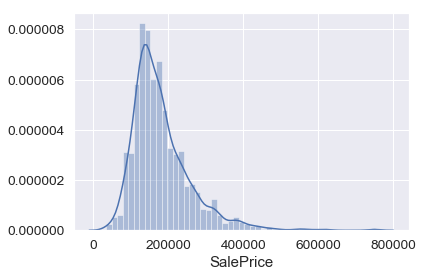

In [161]:
sns.distplot(df_train['SalePrice'])

Looking at our dependent variable SalePrice we can see its deviation from normal distribution, in addition to positive skewness and high peakiness which we will solve in our data cleaning process.

I'll show some correlations with the parameters I hypothesised to have correlation with SalePrice

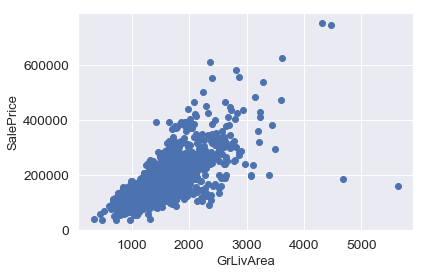

In [162]:
### GRLivArea
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

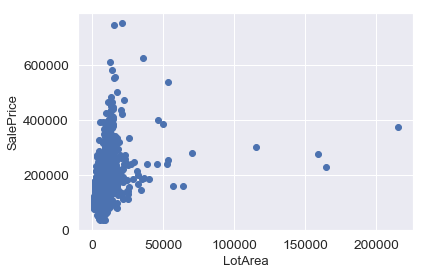

In [163]:
### LotArea
fig, ax = plt.subplots()
ax.scatter(x = df_train['LotArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

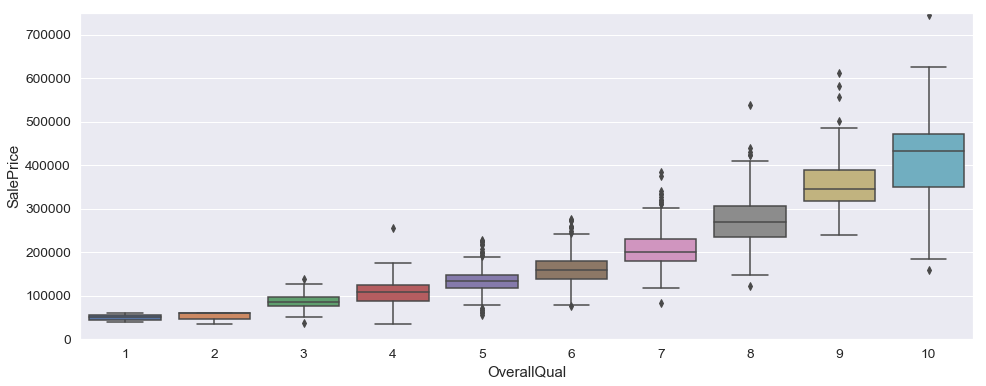

In [164]:
### OverallQual
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=750000);

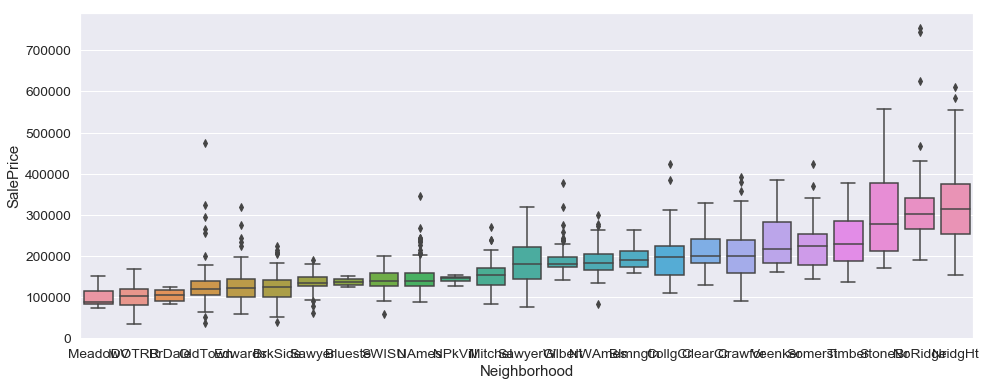

In [165]:
### Neighborhood
var = 'Neighborhood'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 6))
sorted_nb = df_train.groupby(['Neighborhood'])['SalePrice'].median().sort_values()
sns.boxplot(x=df_train['Neighborhood'], y=df_train['SalePrice'], order=list(sorted_nb.index))
fig.axis(ymin=0, ymax=750000);

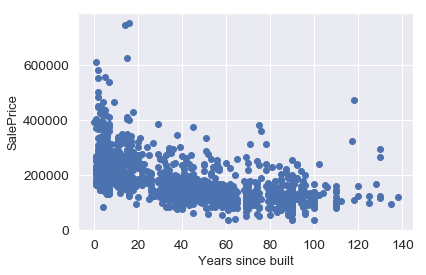

In [166]:
### YearBuilt
fig, ax = plt.subplots()
ax.scatter(x = 2010-df_train['YearBuilt'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Years since built', fontsize=13)
plt.show()

# 3. Data exploration

I chose to show only the correlation with the univariate variables I mentioned earlier, and we can see that the correlation trend is as expected. However, since we have many additional variables I'll use a heat-map to exemplify some of the correlations with other variables

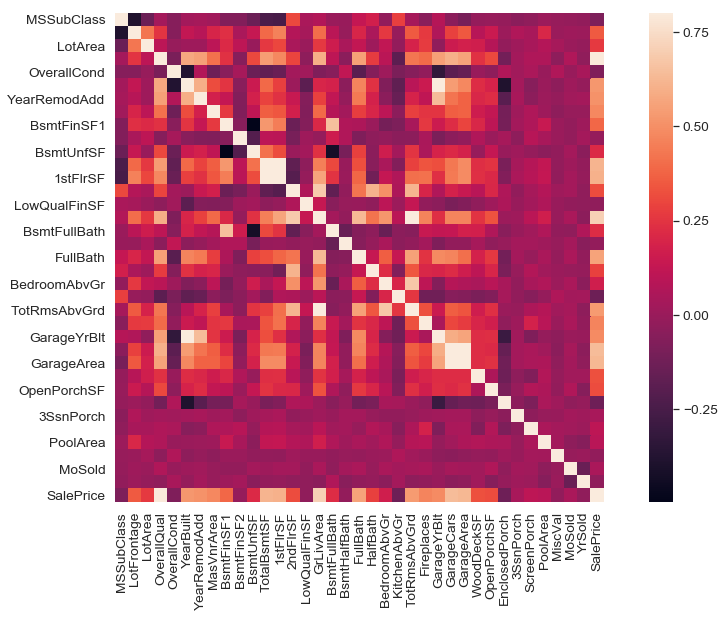

In [167]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

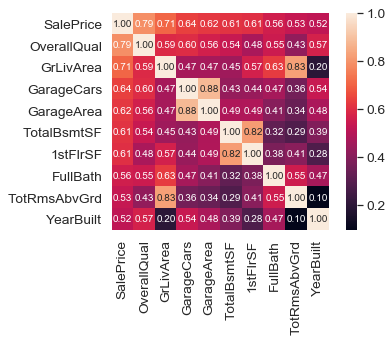

In [168]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,)
plt.show()

To summarize this part, we can identify high correlation with additional variables, such as GarageArea and GarageCars. We will look into it further in the feature importance and feature redundancy part.

# 4. Data cleaning

### a. Data cleaning functions

In [169]:
def add_na_col(df, col, filler, name):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum():
            df[name+'_na'] = pd.isnull(col)
            df[name] = col.fillna(filler)

In [170]:
# Error measurment for linear regression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model, df_x, df_y):
    rmse= np.sqrt(-cross_val_score(model, df_x, df_y, scoring = scorer, cv = 10))
    return(rmse)

In [171]:
# Error measurment for random forest
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print (res)

In [172]:
# Error measurment for model stacking
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_trn.values)
    rmse= np.sqrt(-cross_val_score(model, df_trn.values, y_trn, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [173]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [174]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [175]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

### b. Data cleaning process

To begin with, I'll remove the outliers we saw in the dependent variable

In [176]:
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)


 mu = 180932.92 and sigma = 79467.79



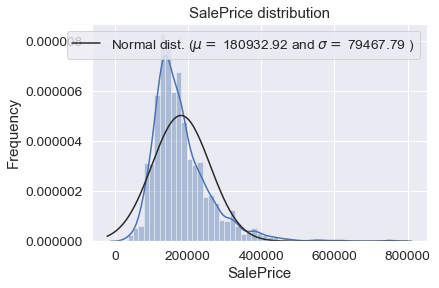

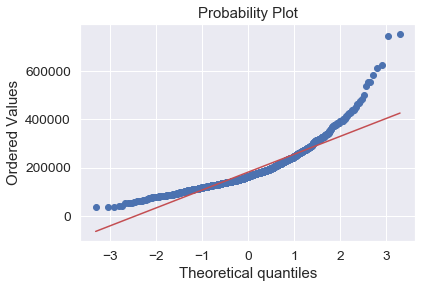

In [177]:
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

In [178]:
# To reduce the skenwess and peakiness of the SalePrice variable, we'll apply log(x+1) on the column. 
#The outcome isn't normal distribution by the book, but it's relatively close to it
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])


 mu = 12.02 and sigma = 0.40



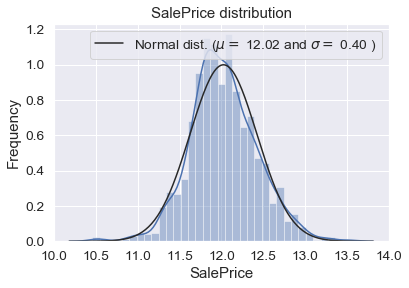

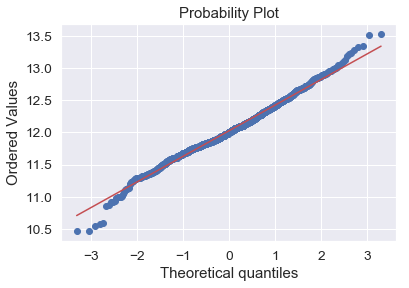

In [179]:
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

I'm creating a joint data set of the train and test data sets before applying the data cleaning functions

In [180]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_trn = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


First step is to fill the null values for the numerical and categorical variables

In [181]:
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageFinish,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageCond,159,0.054508


In [182]:
for col in ('PoolQC','MiscFeature','Alley','MSSubClass','Fence','FireplaceQu','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','MasVnrType'):
    all_data[col] = all_data[col].fillna("None")

In [183]:
for col in ('MasVnrArea','GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [184]:
for col in ('Exterior1st','Exterior2nd','KitchenQual','Electrical','MSZoning','SaleType','Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [185]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median())) 

In [186]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [187]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [188]:
# Verifying all missing data is filled
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TotalSF,0,0.0
YrSold,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0
Exterior1st,0,0.0
Exterior2nd,0,0.0
Fence,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Foundation,0,0.0


Second step is to change categorical variables to strings

In [189]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Third step is to encode categorical variables based on their order

In [190]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))


In [191]:
all_data["HighSeason"] = all_data["MoSold"].replace( {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
all_data["NewerDwelling"] = all_data["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})  


Fourth step is to balance the skewness of all numerical variables

In [192]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [193]:
skewness = skewness[abs(skewness) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


There are 61 skewed numerical features to Box Cox transform


The last step is to add dummy variables 

In [194]:
all_data = pd.get_dummies(all_data, dummy_na=True)

In [195]:
df_trn = all_data[:ntrain]
df_tst = all_data[ntrain:]

# 5. Data regression tests

I'm testing the data set utilizing three different regression methods, as we can see in the following sections, each method can be configured in several ways and the results can be interpreted differently. I selected these specific methods to showcase the vast range of algorithms and ways to experiment with the data from basic regression to more advanced ML algorithms. I didn't touch DL algorithms in this case, however, it's also a legitimate possibility.

## a. Linear regression with Lasso regularization

Linear regression using LASSO regularization (least absolute shrinkage and selection operator). I chose to work with Lasso since during the data cleaning process we added many new variables, with Lasso regularization the regression process will ignore (multiply by 0) the variables that the algorithm shows aren't important and will take into account only the features that have significant important, whereas a regularization like Ridge can ignore these non-significant variables.

First step is to find the best alpha for the Lasso

In [196]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(df_trn, y_trn)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0003


Like in many cases, the selected error matrix is the root mean square error of the log of the sale price

In [197]:
print("Lasso RMSE on Training set :", rmse_cv(lasso, df_trn, y_trn).mean())

Lasso RMSE on Training set : 0.11146913194483136


In the results, we can see that the Lasso picked 88 features and eliminated 160 features to reach the final 
regression outcome. 
A few key insights from the coefficients - 
1. Overall quality has the most significant positive impact on house prices, seconded by the overall condition of the
house, which wasn't in our initial hypothesis.
2. The neighborhood coefficients show how the location can have positive or negative impact on the prices, depends on
the specific neighborhood.
3. On the negative coefficients, we can see that the roof material has outstanding impact on the price, which is a very interesting insight to mention to house owners - it might be the case that installing new roof can translate into immediate rise in the house price and cover the initial investment.

Lasso picked 109 features and eliminated the other 136 features


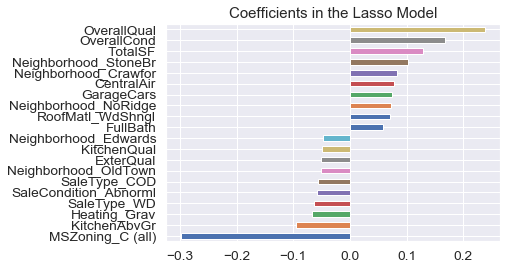

In [198]:
coefs = pd.Series(lasso.coef_, index = df_trn.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## b. Random forest regression

Random forest is an algorithm which is quite popular in many use cases. I use this supervised learning algorithm both here and in the model stacking section. I chose to showcase different ways to configure the random forest base on the interpretation of the output of the algorithm.

I split the training data set into training and validation sets so we can experiment with the algorithm and modify its internal decision trees.

In [199]:
n_valid = 700  
n_trn = len(df_trn)-n_valid
raw_train, raw_valid = split_vals(df_trn, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((758, 245), (758,), (700, 245))

In [200]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.057083746280517, 0.14095516397382454, 0.9809161372361732, 0.8653152689359214]


Since Random forest is dependent on the number of estimators, we can see that as the number of estimators grow the accuracy of the algorithm improves, up to a point where the outcome reaches its peak and adding more estimators won't impact the outcome. I used it to select the optimal number of estimators - with trade-off of performance vs accuracy.

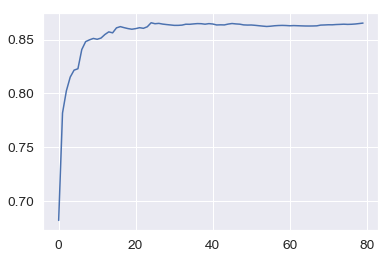

In [201]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]
preds.shape
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(80)]);

In [202]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.05654603253384915, 0.14047798408540751, 0.9812739737475287, 0.8662256301809411]


In [203]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05407038825238775, 0.1363431147972756, 0.9828777700009712, 0.8739848374758058, 0.8760915865275526]


Looking at the feature importance analysis of the algorithm, we can see that the outcome differs from what we had in the linear regression - as expected. Some insights we can see here - 
1. It better correlates with our initial hypothesis - size, age and quality are the most significant features.
2. The size of the house and the living area are significantly more important than the size of the lot.
3. In this model, the overall condition and the roof type are less important, however, garage is of great importance to the price of the house - size and condition.

In [204]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
58,TotalSF,0.345364
46,OverallQual,0.190985
30,GrLivArea,0.089541
55,YearBuilt,0.041412
25,GarageCars,0.028306
22,FullBath,0.025447
29,GarageYrBlt,0.025034
24,GarageArea,0.023642
18,ExterQual,0.018474
53,TotalBsmtSF,0.015353


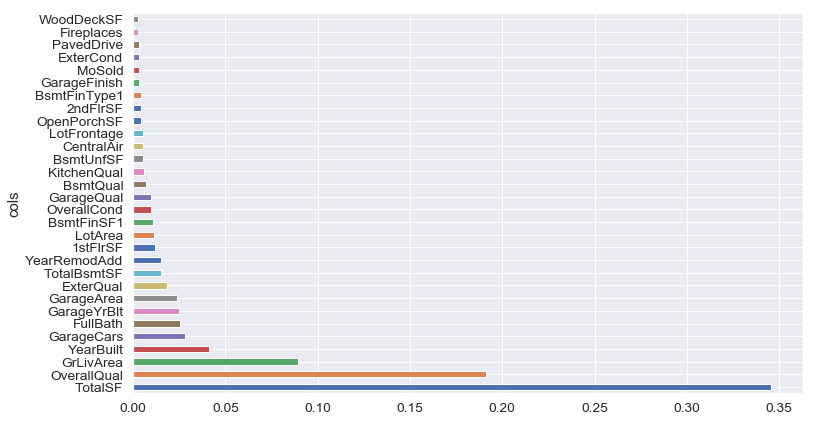

In [205]:
plot_fi(fi[:30]);

In [206]:
to_keep = fi[fi.imp>0.005].cols 
len(to_keep)

21

In [207]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

One last experiment I wanted to show is the Random forest with a data set which contains only the 20 most important features and compare it to the original version with all the features - 

In [208]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09187836936431781, 0.14405307988302954, 0.9505612014454645, 0.8593300033220131, 0.8559656960181025]


Lastly, we can see that there are no variables which are redundant. There's a significant distance between the variables in the tree.

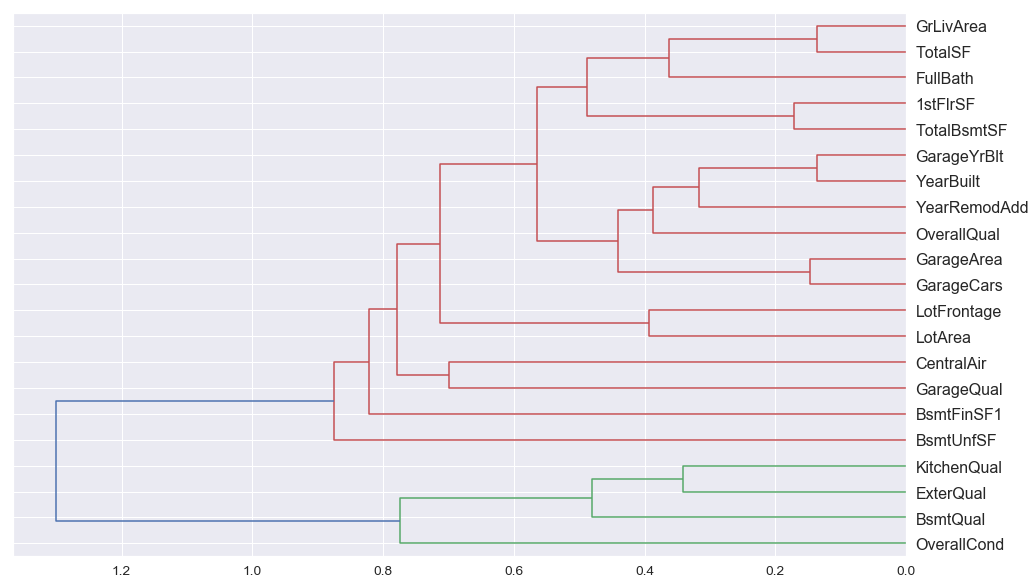

In [209]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

## c. Model stacking

The last algorithm and the one which showed the best results is the model stacking algorithm. In this case we work in several steps - we start with base models and check their cross-validation using the same matrices we used previously. I chose to use 6 folds to make it on the one hand reasonably light - the more folds and base models I add, the more complexed and time-consuming the model will be, and with low RMSLE and robust on the other hand. 

The base models are the following - Lasso regression, Ridge regression, Elastic net, Random forest and three methods of gradient boost - Gradient boost, XGboost and Light GBM. These algorithms are common and popular and supported by sklearn library.

In [210]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [211]:
#Validation function
n_folds = 6

In [212]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
RF = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)

In [213]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1110 (0.0099)



In [214]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1108 (0.0099)



In [215]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1134 (0.0098)



In [216]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1165 (0.0110)



In [217]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1163 (0.0087)



In [218]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1159 (0.0102)



In [219]:
score = rmsle_cv(RF)
print("RF score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

RF score: 0.1319 (0.0095)



After seeing the cross-validation of all the base models and configuring the parameters of each of the base models, we can move forward to the next step - stacking the models. 
The process is the following - 
1. Split the data into two sets - train and holdout.
2. Split the train data into six folds - based on the number of base models we selected.
3. Iteratively train each base model on each of the folds but the holdout fold and predict on the holdout fold.
4. After 6 iterations the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model
5. Use the out-of-folds predictions as the inputs, and the target variables as the outputs to train a higher level learner called meta-model.
6. The final prediction is done with the meta-model

In [220]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=6):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [221]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, RF),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1077 (0.0097)


In [222]:
stacked_averaged_models.fit(df_trn.values, y_trn)
stacked_train_pred = stacked_averaged_models.predict(df_trn.values)

In [223]:
stacked_pred = np.expm1(stacked_averaged_models.predict(df_tst.values))

In [224]:
print(rmsle(y_trn, stacked_train_pred))

0.07696779805922163


In [225]:
model_xgb.fit(df_trn, y_trn)
xgb_train_pred = model_xgb.predict(df_trn)
xgb_pred = np.expm1(model_xgb.predict(df_tst))
print(rmsle(y_trn, xgb_train_pred))

0.07859917334306196


In [226]:
model_lgb.fit(df_trn, y_trn)
lgb_train_pred = model_lgb.predict(df_trn)
lgb_pred = np.expm1(model_lgb.predict(df_tst.values))
print(rmsle(y_trn, lgb_train_pred))

0.0720852384345591


In [227]:
print('RMSLE score on train data:')
print(rmsle(y_trn,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07440739815486887


We can see that the performance of the stacking is significantly better than the previous models or of each of the models independently. I skipped the feature importance part here but in general I planned to get the feature importance of each of the base models, normalize it and use weighted average based on the performance of each of the models.